In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import numpy     as np
import xarray    as xr
import time      as clock
import warnings
xr.set_options(keep_attrs=True)
client_runs   = False

/albedo/home/pscholz/tripyview


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [2]:
# parameters
#___Dask Client Parameters____________________________________________________________
do_papermill      = False
do_parallel       = False
parallel_tnprc    = 128                          # total number of available CPUs
parallel_nprc     = 72                           # number of dask workers
parallel_nprc_bin = parallel_tnprc-parallel_nprc # number of processor used to parallize the binning loop
parallel_tmem     = 200                          # max. available RAM

#___Mesh Path & Save Path_____________________________________________________________
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path         = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
save_path         = None #'~/figures/test_papermill/'
save_fname        = None # filename from papermill come in through save_fname
tripyrun_name     = None # papermill workflow name of notebook 
tripyrun_analysis = None # papermill diagnostic driver
tripyrun_spath_nb = None # papermill path to processed notebooks
tripyrun_spath_fig= None # papermill path to processed figures

#___Data Path & Input Names___________________________________________________________
input_paths   = list()
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')

input_names   = list()
input_names.append('TKE+IDEMIX, jayne')
input_names.append('TKE+IDEMIX, nycander')
input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl    = None
do_allcycl= False
vname     = 'isotdep'
year      = [1979, 2019]
mon       = None
day       = None
record    = None 
box       = None
depth     = 1000
which_isotherm = 12.0


#___Define Reference Data, Year, Mon ...______________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None # '/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/'
ref_name  = None # 'TKE'
ref_year  = None #[1979, 2019]
ref_mon   = None
ref_day   = None
ref_record= None

#___Define Climatology________________________________________________________________
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'

#___Define Colormap Parameters________________________________________________________
# papermill doesnt like multi variable alignment in a single line
cstr      = 'wbgyr'
cnum      = 15
cref      = None
crange    = None
cmin      = None
cmax      = None
cfac      = None
climit    = None
chist     = True
ctresh    = 0.995

ref_cstr  = 'wbgyr'
ref_cnum  = 15
ref_cref  = None
ref_crange= None
ref_cmin  = None
ref_cmax  = None
ref_cfac  = None
ref_climit= None
ref_chist = True
ref_ctresh= 0.995

#___Define Plot Parameters____________________________________________________________
ncol              = 2      # number of pannel columns in figure
nrow              = None
proj              = 'rob' 
box               = [-180, 180, -90, 90]
do_plt            = 'tcf'  # plot pcolor (tpc) or contourf (tcf)
plt_contb         = True   # background contour line (thin)
plt_contf         = False  # contour line of main colorbar steps 
plt_contr         = False  # contour line of reference value 
plt_contl         = False  # label contourline of main colorbar steps 
do_rescale        = None   # rescale data: None, 'log10', 'slog10', np.array(...)
do_lsm            ='fesom' # 'fesom', 'bluemarble', 'etopo', 'stock'
do_mesh           = False, 
mesh_opt          = dict({'color':'k', 'linewidth':0.10})
do_enum           = False  # do enumeration of panels
do_reffig         = True   # plot reference fig when doing anomalies 
do_clim           = False   # plot climatolgy values when doing absoluts
ax_title          = None
cb_label          = None
save_dpi          = 300
save_fmt          = ['png']

In [3]:
# start parallel dask client
if do_parallel and not client_runs:
    from dask.distributed import Client
    from dask import config as cfg
    cfg.set({'distributed.scheduler.worker-ttl': None})
    ##import dask
    ## dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
    print(' --> memory_limit: {:3.3f} GB'.format(parallel_tmem/(parallel_nprc)))
    client = Client(n_workers=parallel_nprc, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(parallel_tmem/parallel_nprc))
    client_runs = True
    client

In [4]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________
if (n_cycl is not None): 
    cycl_s=1 if do_allcycl else n_cycl
    #__________________________________________________________________________________________________
    aux_path, aux_name = list(), list()
    input_paths_old, input_names_old = input_paths, input_names
    for ii, (ipath,iname) in enumerate(zip(input_paths,input_names)):
        for ii_cycl in range(cycl_s, n_cycl+1):
            aux_path.append(os.path.join(ipath,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(iname))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, iname))
            print(ii, aux_path[-1],aux_name[-1])
    input_paths, input_names = aux_path, aux_name
    
    #__________________________________________________________________________________________________
    if (ref_path is not None): 
        aux_path, aux_name = list(), list()
        ref_path_old, ref_name_old = ref_path, ref_name
        for ii_cycl in range(cycl_s, n_cycl+1):
            aux_path.append(os.path.join(ref_path,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(ref_name))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, ref_name))
            print('R', ref_path[-1])        
        ref_path, ref_name = aux_path, aux_name
    del(aux_path, aux_name)  

#______________________________________________________________________________________________________
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path != None): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record
    cinfo.update({'cref':0.0})
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)
    
#______________________________________________________________________________________________________    
# concatenate list = list1+list2
if (ref_path != None): 
    if isinstance(ref_path, list): 
        input_paths, input_names = ref_path + input_paths        , ref_name + input_names
    else:    
        input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names
        
#__________________________________________________________________________________________________    
def compute_isotherm_depth(data, which_isotherm):
    
    #__________________________________________________________________________________________________    
    vname = list(data.keys())[0]
    auxithermz = np.zeros((data.dims['nod2'], ))
    for ni in range(data.dims['nod2']):
        auxtemp, auxzmid = data[vname].isel(nod2=ni).data.copy(), np.abs(data.coords['nz1'].data.copy())
        if np.any(auxtemp>=which_isotherm):
            isok   = np.isnan(auxtemp)==False
            auxtemp, auxzmid = auxtemp[isok], auxzmid[isok]
            idsort = np.argsort(auxtemp)
            auxtemp, auxzmid = auxtemp[idsort], auxzmid[idsort]
            auxithermz[ni] = np.interp(which_isotherm, auxtemp, auxzmid)
            del(auxtemp, auxzmid, isok, idsort)
        else: continue 
    #__________________________________________________________________________________________________    
    isotdep = xr.Dataset(data_vars = {'isotdep': ('nod2', auxithermz, data['temp'].attrs)},
                             coords    = {'lon'    : data.coords['lon'], 
                                          'lat'    : data.coords['lat'], 
                                          'w_A'    : data.coords['w_A'].isel(nz1=0)},
                             attrs     = data.attrs)
    isotdep['isotdep'].attrs['long_name'  ] = 'depth of {}°C isotherm'.format(which_isotherm)
    isotdep['isotdep'].attrs['description'] = 'depth of {}°C isotherm'.format(which_isotherm)
    isotdep['isotdep'].attrs['units'      ] = 'm'
    isotdep.attrs['proj'] = proj
    #__________________________________________________________________________________________________    
    return(isotdep)        

 > found *.pckl file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.pckl file: tripyview_fesom2_core2_srt_dep@node_focus0.pckl
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________


In [5]:
data_list = list()

#___APPEND ABS CLIMATOLOGY_____________________________________________________________________________    
if (depth != 'bottom') and do_clim and (ref_path is None): 
    ts = clock.time()
    clim_vname = 'temp'
    if   clim_vname=='temp' and  which_clim.lower()=='woa18': clim_vname = 't00an1'
    elif clim_vname=='salt' and  which_clim.lower()=='woa18': clim_vname = 's00an1'
    clim = tpv.load_climatology(mesh, clim_path, clim_vname, depth=None)
    clim = compute_isotherm_depth(clim, which_isotherm)
    print(' --> elasped time to load clim: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> clim uses {:3.2f} Gb:'.format(clim.nbytes/(1024**3)))
    data_list.append(clim)    
    del(clim)
    
    
#___LOAD FESOM2 DATA___________________________________________________________________________________
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)):
    print(ii, datapath, descript)
    ts = clock.time()
    #__________________________________________________________________________________________________
    yeari, moni, dayi, recordi = year, mon, day, record
    if (ii==0) and (ref_path != None): yeari, moni, dayi, recordi = ref_year, ref_mon, ref_day, ref_record
    #__________________________________________________________________________________________________
    data = tpv.load_data_fesom2(mesh, datapath, vname='temp', year=yeari, mon=moni, day=dayi, record=recordi, 
                                depth=None, descript=descript, do_info=False, do_zarithm=None)
    
    #__________________________________________________________________________________________________    
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    
    #__________________________________________________________________________________________________    
    # compute isotherm depth
    data_isotdep = compute_isotherm_depth(data, which_isotherm)
    del(data)        
    print(' --> elasped time to load data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data_isotdep.nbytes/(1024**3)))
    print('')
    
    #__________________________________________________________________________________________________    
    # create reference data if given 
    if (ii==0) and (ref_path != None):
        data_isotdep_ref = data_isotdep
        if do_reffig: data_list.append(data_isotdep_ref) 
        continue
        
    #__________________________________________________________________________________________________    
    # compute anomaly 
    if (ref_path != None):
        data_list.append(tpv.do_anomaly(data_isotdep, data_isotdep_ref))  
    # compute absolute    
    else:
        data_list.append(data_isotdep)  
    del(data_isotdep)
if (ref_path != None): del(data_isotdep_ref)

0 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/ TKE+IDEMIX, jayne
 --> elasped time to load data: 0.59 min.
 --> data uses 0.00 Gb:

1 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/ TKE+IDEMIX, nycander
 --> elasped time to load data: 0.64 min.
 --> data uses 0.00 Gb:

2 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/ TKE+IDEMIX, stormtide
 --> elasped time to load data: 0.64 min.
 --> data uses 0.00 Gb:

3 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/ TKE
 --> elasped time to load data: 0.64 min.
 --> data uses 0.00 Gb:



/albedo/home/pscholz/.conda/envs/newpy38/lib/python3.8/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


--> histo: cmin, cmax =  -1.7625 717.3375000000001
--> histo: cmin, cmax =  -1.7625 717.3375000000001
--> histo: cmin, cmax =  -1.7625 717.3375000000001
--> histo: cmin, cmax =  -1.7625 717.3375000000001
{'cstr': 'wbgyr', 'cnum': 15, 'chist': True, 'ctresh': 0.995, 'cnlab': 8, 'cmin': -1.76, 'cmax': 717.34, 'cref': 400.0, 'cmap': <matplotlib.colors.ListedColormap object at 0x7fbe28760df0>, 'clevel': array([-25.,   0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225.,
       250., 275., 300., 325., 350., 375., 400., 425., 450., 475., 500.,
       525., 550., 575., 600., 625., 650., 675., 700., 725.]), 'clab': array([  0., 100., 200., 300., 400., 500., 600., 700.])}


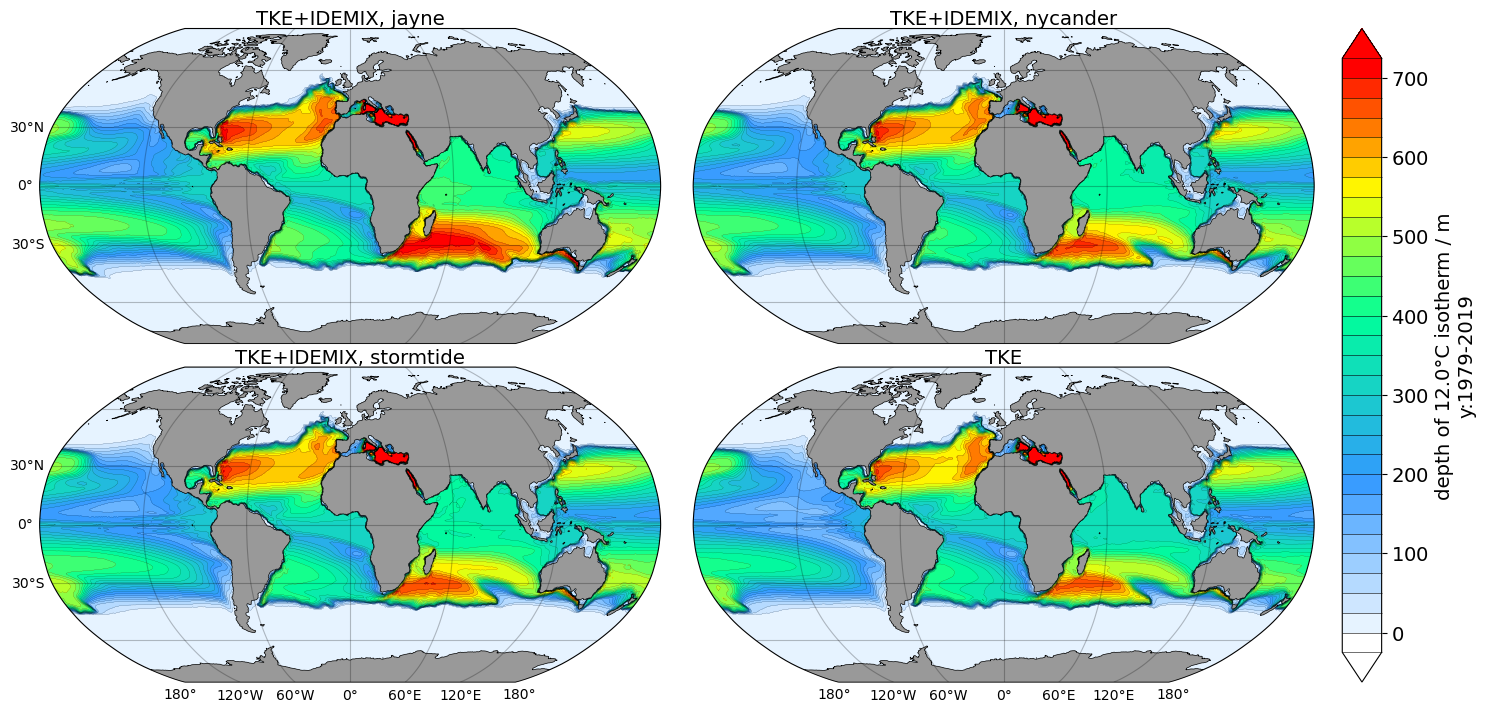

In [6]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
ndat   = len(data_list)
if   ncol != None: 
    ncol0  = np.min([ncol,ndat])    
    nrow0  = np.ceil(ndat/ncol0).astype('int')
elif nrow != None: 
    nrow0  = np.min([nrow,ndat])    
    ncol0  = np.ceil(ndat/nrow0).astype('int')
    
idx=1 if do_clim else 0       
svname = list(data_list[idx].data_vars)[0]
slabel = data_list[idx][svname].attrs['str_lsave']

#______________________________________________________________________________________________________
# do save filename path
spath  = save_path
sfpath = None
if spath!=None: 
    sfpath=list()
    for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}.{:s}'.format(svname, proj, slabel, sfmt)) )
if save_fname!=None: sfpath = [save_fname] # --> needed for diagrun papermille functionality

#______________________________________________________________________________________________________
# do colorbar either single cbar or ref_cbar + anom_cbar
if (ref_path != None) and do_reffig: cb_plt, cb_plt_single, cinfo0 = [1]+[2]*(nrow0*ncol0-1), False, [ref_cinfo.copy(), cinfo.copy()]
else: cb_plt, cb_plt_single, cinfo0 = True, True, cinfo.copy() 

#__________________________________________________________________________________________________
hfig, hax, hcb = tpv.plot_hslice(mesh, data_list, cinfo=cinfo0, box=box, nrow=nrow0, ncol=ncol0, proj=proj, do_rescale=do_rescale,  
                                do_plt=do_plt, plt_contb=plt_contb, plt_contf=plt_contf, plt_contr=plt_contr, plt_contl=plt_contl, do_enum=do_enum, 
                                ax_opt=dict({'fig_sizefac':2.0, 'cb_plt':cb_plt, 'cb_plt_single':cb_plt_single, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(),
                                do_save=sfpath, save_dpi=save_dpi)  

In [7]:
if do_papermill and do_parallel and client_runs:
    client.shutdown()
    client_runs = False